# Coursework OffensEval 2019
Shu Okabe

In [0]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import io
import string
import re

# NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducible results
np.random.seed(24)
torch.manual_seed(24)

In [2]:
# Load the data from the computer
from google.colab import files
uploaded = files.upload()

# Remove a file from colab
#!rm offenseval-training-v1.tsv

Saving offenseval-training-v1.tsv to offenseval-training-v1 (2).tsv


In [3]:
# Read the data
df = pd.read_csv(io.StringIO(uploaded["offenseval-training-v1.tsv"].decode('utf-8')),  sep = "\t")
print(df.shape)
df.head()

(13240, 5)


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [0]:
# Load the data on Jupyter Notebook
#path = './Downloads/start-kit/training-v1/'

#path = './training-v1/'
#df = pd.read_csv(path + "offenseval-training-v1.tsv", sep = "\t")
#print(df.shape)
#df.head()

# Descriptive statistics

In [5]:
# General information on the distribution of the classes in the dataset.
df.describe(include = ['O'])

,tweet,subtask_a,subtask_b,subtask_c
count,13240,13240,4400,3876
unique,13207,2,2,3
top,@USER Looks Like The Jokes On Liberals Again. ...,NOT,TIN,IND
freq,6,8840,3876,2407


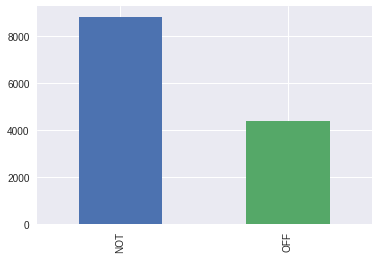

In [6]:
# Distribution of the labels for sub-task A
df['subtask_a'].value_counts().plot(kind = 'bar')

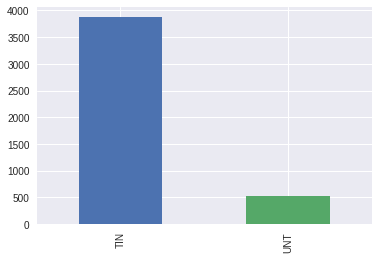

In [7]:
# Distribution of the labels for sub-task B
df['subtask_b'].value_counts().plot(kind = 'bar')

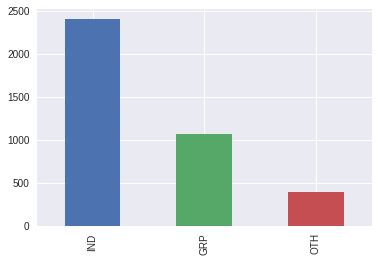

In [8]:
# Distribution of the labels for sub-task C
df['subtask_c'].value_counts().plot(kind = 'bar')

We can thus see that the labels are rather inequally distributed, especially for the sub-task B where thee class 'TIN' is much more represented in the training data. Hence, for this classification task the F1 score is the most important metrics.

# Preprocessing of the tweets

## Remove punctuation and transform to lowercase

In [9]:
df_prep = df.copy()
#df_prep['preprocessed_tweet'] = df_prep['tweet'].str.replace(' URL ', ' ')
df_prep['preprocessed_tweet'] = df_prep['tweet'].str.lower() # Lowercase
df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('&amp;', '&')
df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[{}]'.format(string.punctuation), '')
df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[“”’—]', ' ')
df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('\d+', '') # Remove digits

def replace_words(dataframe, label):
    dataframe[label] = dataframe[label].str.replace('𝙿𝚎𝚝𝚊𝚕𝚜', 'Petals')
    dataframe[label] = dataframe[label].str.replace('𝙼𝚌𝙿𝙾𝚄𝚃𝚂𝙵𝚊𝚌𝚎', 'McPOUTSFace')
    dataframe[label] = dataframe[label].str.replace('ᶦˢ', 'is')
    dataframe[label] = dataframe[label].str.replace('ᴵⁿᵈᵉˣ', 'index')
    dataframe[label] = dataframe[label].str.replace('ᶠᶦʳˢᵗ', 'first')
    dataframe[label] = dataframe[label].str.replace('ᵗʰᵉ', 'the')
    dataframe[label] = dataframe[label].str.replace('ᴳᵉᵗᵗᶦⁿᵍ', 'getting')
    return dataframe
  
df_prep = replace_words(df_prep, 'preprocessed_tweet')

df_prep.head(10)

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,user she should ask a few native americans wha...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,user user go home you re drunk user maga trump...
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,user someone shouldvetaken this piece of shit ...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,user user obama wanted liberals illegals to m...
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH,user liberals are all kookoo
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN,user user oh noes tough shit
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP,user was literally just talking about this lol...
8,45157,@USER Buy more icecream!!!,NOT,NaN,NaN,user buy more icecream
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND,user canada doesn t need another cuck we alrea...


## Tokenisation

In [10]:
token_df = df_prep.copy()
token_df['token_tweet'] = token_df.preprocessed_tweet.apply(lambda x: x.split())
#print(token_df.token_tweet.iloc[1])
token_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet,token_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,user she should ask a few native americans wha...,"[user, she, should, ask, a, few, native, ameri..."
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,user user go home you re drunk user maga trump...,"[user, user, go, home, you, re, drunk, user, m..."
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...,"[amazon, is, investigating, chinese, employees..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,user someone shouldvetaken this piece of shit ...,"[user, someone, shouldvetaken, this, piece, of..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,user user obama wanted liberals illegals to m...,"[user, user, obama, wanted, liberals, illegals..."


## Remove stopwords

In [11]:
stopwords = nltk.corpus.stopwords.words('english')
#print(stopwords)

mystopwords = stopwords + ['u', 'im', 'also']

token_df['token_tweet_stop'] = token_df['token_tweet'].apply(lambda x: [item for item in x if item not in mystopwords])
token_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet,token_tweet,token_tweet_stop
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,user she should ask a few native americans wha...,"[user, she, should, ask, a, few, native, ameri...","[user, ask, native, americans, take]"
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,user user go home you re drunk user maga trump...,"[user, user, go, home, you, re, drunk, user, m...","[user, user, go, home, drunk, user, maga, trum..."
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...,"[amazon, is, investigating, chinese, employees...","[amazon, investigating, chinese, employees, se..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,user someone shouldvetaken this piece of shit ...,"[user, someone, shouldvetaken, this, piece, of...","[user, someone, shouldvetaken, piece, shit, vo..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,user user obama wanted liberals illegals to m...,"[user, user, obama, wanted, liberals, illegals...","[user, user, obama, wanted, liberals, illegals..."


In [12]:
# Remove some columns
sub_token_df = token_df[['id', 'token_tweet_stop', 'subtask_a', 'subtask_b', 'subtask_c']] 
sub_token_df.rename(columns = {'token_tweet_stop':'tweet'}, inplace = True)

print(token_df.shape, sub_token_df.shape)
sub_token_df.head()

(13240, 8) (13240, 5)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,"[user, ask, native, americans, take]",OFF,UNT,NaN
1,90194,"[user, user, go, home, drunk, user, maga, trum...",OFF,TIN,IND
2,16820,"[amazon, investigating, chinese, employees, se...",NOT,NaN,NaN
3,62688,"[user, someone, shouldvetaken, piece, shit, vo...",OFF,UNT,NaN
4,43605,"[user, user, obama, wanted, liberals, illegals...",NOT,NaN,NaN


## Create vocabulary 

In [13]:
def vocabulary_list(dataframe, label):
    voc = [] # Put all the tokens appearing in the vocabulary in a list
    for index, row in dataframe.iterrows():
        tweet = row[label]
        for token in tweet:
            if token not in voc:
                voc.append(token)
    return voc

vocabulary = vocabulary_list(sub_token_df, 'tweet')
print(vocabulary[1:20])

vocabulary_size = len(vocabulary)
vocabulary_size

['ask', 'native', 'americans', 'take', 'go', 'home', 'drunk', 'maga', 'trump', '👊🇺🇸👊', 'url', 'amazon', 'investigating', 'chinese', 'employees', 'selling', 'internal', 'data', 'thirdparty']


21024

## Lemmatisation

In [14]:
def lemmatisation(dataframe, label, porter = True):
    if porter:
        lemmatizer = PorterStemmer()
        dataframe['tweet_lemma'] = dataframe[label].apply(lambda row: [lemmatizer.stem(word)  for word in row])
    else:
        lemmatizer = WordNetLemmatizer()
        dataframe['tweet_lemma'] = dataframe[label].apply(lambda row: [lemmatizer.lemmatize(word)  for word in row])
    return dataframe

sub_token_df = lemmatisation(sub_token_df, 'tweet', False)
sub_token_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,id,tweet,subtask_a,subtask_b,subtask_c,tweet_lemma
0,86426,"[user, ask, native, americans, take]",OFF,UNT,NaN,"[user, ask, native, american, take]"
1,90194,"[user, user, go, home, drunk, user, maga, trum...",OFF,TIN,IND,"[user, user, go, home, drunk, user, maga, trum..."
2,16820,"[amazon, investigating, chinese, employees, se...",NOT,NaN,NaN,"[amazon, investigating, chinese, employee, sel..."
3,62688,"[user, someone, shouldvetaken, piece, shit, vo...",OFF,UNT,NaN,"[user, someone, shouldvetaken, piece, shit, vo..."
4,43605,"[user, user, obama, wanted, liberals, illegals...",NOT,NaN,NaN,"[user, user, obama, wanted, liberal, illegals,..."


In [15]:
# Lemmatised vocabulary
voc_lemma = vocabulary_list(sub_token_df, 'tweet_lemma')
print(voc_lemma[1:20])

voc_lemma_size = len(voc_lemma)
voc_lemma_size

['ask', 'native', 'american', 'take', 'go', 'home', 'drunk', 'maga', 'trump', '👊🇺🇸👊', 'url', 'amazon', 'investigating', 'chinese', 'employee', 'selling', 'internal', 'data', 'thirdparty']


19199

In [0]:
# Mapping from word to index and index to word. 

word2idx = {w: idx for (idx, w) in enumerate(voc_lemma)}
idx2word = {idx: w for (idx, w) in enumerate(voc_lemma)}

In [17]:
sub_token_df['len_tweet'] = sub_token_df['tweet_lemma'].apply(len)
max_len_tweet = max(sub_token_df.len_tweet)
print('Maximum number of words (tokens) in the tweet:', max_len_tweet)
sub_token_df.head()

Maximum number of words (tokens) in the tweet: 79


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,tweet,subtask_a,subtask_b,subtask_c,tweet_lemma,len_tweet
0,86426,"[user, ask, native, americans, take]",OFF,UNT,NaN,"[user, ask, native, american, take]",5
1,90194,"[user, user, go, home, drunk, user, maga, trum...",OFF,TIN,IND,"[user, user, go, home, drunk, user, maga, trum...",10
2,16820,"[amazon, investigating, chinese, employees, se...",NOT,NaN,NaN,"[amazon, investigating, chinese, employee, sel...",19
3,62688,"[user, someone, shouldvetaken, piece, shit, vo...",OFF,UNT,NaN,"[user, someone, shouldvetaken, piece, shit, vo...",7
4,43605,"[user, user, obama, wanted, liberals, illegals...",NOT,NaN,NaN,"[user, user, obama, wanted, liberal, illegals,...",9


# Sub-task A

## Split the data for sub-task A into three datasets

In [18]:
# Extract necessary columns
fin_df_a = sub_token_df[['id', 'tweet_lemma', 'subtask_a']]
fin_df_a.rename(columns = {'tweet_lemma':'tweet'}, inplace = True)

# Train Test Val Split with a ratio of 80:20:20
df_train, df_test = train_test_split(fin_df_a, test_size = 0.2, random_state = 24)
df_train, df_val = train_test_split(df_train, test_size = 0.25, random_state = 24)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(7944, 3)
(2648, 3)
(2648, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Transform the given data into an input for the neural network

In [19]:
def get_model_inputs(dataframe, word2idx, column, target, max_len):
    # Input
    data = dataframe.copy()

    # Converts words to index
    data['index_tweet'] = data.tweet.apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])

    # Create a tensor of a fixed size filled with zeroes for padding
    #data_tensor = Variable(torch.zeros((len(dataframe), max_len, embedding)))#.long() # Shape: No_tweets x maximum_length of tweets x embedding
    data_tensor = Variable(torch.zeros((len(dataframe), max_len))).long()
    
    # List of the lengths of each tweet
    tweet_lengths = list(data['index_tweet'].map(len).values)

    # Fill with the indexes
    for idx, (indices, tweet) in enumerate(zip(data['index_tweet'], tweet_lengths)):
        if idx % 1000 == 0:
            print(idx)
            
        # With a custom word embedding matrix
        #word = Variable(look_up_table_sent(indices)).float() # Shape: (voc_lemma_size, len(indices))
        #word_emb = torch.matmul(matrix, word).detach().numpy() # Shape: (embedding, len(indices))
        #data_tensor[idx, :tweet] = torch.FloatTensor(word_emb.transpose(1, 0))
        data_tensor[idx, :tweet] = torch.LongTensor(indices)

    # Labels
    labels = dataframe[target].copy()
    labels[labels == 'OFF'] = 1.
    labels[labels == 'NOT'] = 0.
    labels_val = labels.values.astype(dtype = 'float32')
    label_tensor = torch.from_numpy(labels_val)

    return data_tensor, label_tensor

train_data_tensor, train_label_tensor = get_model_inputs(df_train, word2idx, 'tweet', 'subtask_a', max_len_tweet)

print('Shape of the input:', train_data_tensor.shape)

0
1000
2000
3000
4000
5000
6000
7000
Shape of the input: torch.Size([7944, 79])


In [20]:
# Apply the transformation for the validation and test datasets
# Validation
val_data_tensor, val_label_tensor = get_model_inputs(df_val, word2idx, 'tweet', 'subtask_a', max_len_tweet)

# Testing
test_data_tensor, test_label_tensor = get_model_inputs(df_test, word2idx, 'tweet', 'subtask_a', max_len_tweet)

0
1000
2000
0
1000
2000


In [21]:
# Transform the training data into a Pytorch DataLoader object
batch_size = 25 #75

# Data loading
print(train_data_tensor.shape)
train_data = TensorDataset(train_data_tensor, train_label_tensor)
train_dl = DataLoader(train_data, batch_size = batch_size)

torch.Size([7944, 79])


## Two useful metric functions: accuracy and F1 score

In [0]:
def accuracy(output, target):
    output = torch.round(torch.sigmoid(output))
    correct = (output == target).float()
    acc = correct.sum()/len(correct)
    return acc
  
  
def f_measure(output, gold, log = True):
    gold = gold.detach().numpy()

    pred = torch.round(torch.sigmoid(output))
    pred = pred.detach().numpy()
    #print(pred)
   
    test_pos_preds = np.sum(pred)
    test_pos_real = np.sum(gold)
    
    correct = (np.logical_and(pred, gold)).astype(int)
    correct = np.sum(correct)
    #print(correct)

    precision = correct/test_pos_preds
    recall = correct/test_pos_real
  
    fscore = 2.0*precision*recall/(precision+recall)
    
    if log:
        print("Test: Recall: %.2f, Precision: %.2f, F-measure: %.2f\n" % (recall, precision, fscore))
    return fscore

## General variables for the neural network

In [23]:
# Number of epochs
epochs = 20 

# Input dimension: vocabulary size
input_dim = len(word2idx)  #19199 with WordNet
print('Input dimension:', input_dim)

# Embedding dimension: dimensionality of the output of the first layer
embedding_dim = 100

# Dimensionality of the output of the second hidden layer
hidden_dim = 128

# Outut dimension: number of classes, 1 for binary classification
output_dim = 1

Input dimension: 19199


## Some variables specific to CNN

In [0]:
# Number of filters
n_out_channels = 100

# Window size
window_size = 1

# Dropout with the probability 0.5
dropout = 0.5

## Convolutional Neural Network

In [0]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, out_channels, window_size, output_dim, dropout):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size,embedding_dim))
        
        #the dropout layer
        self.dropout = nn.Dropout(dropout)
    
        #the output layer
        self.fc = nn.Linear(out_channels, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)
        
        feature_maps = self.conv(embedded)
        feature_maps = feature_maps.squeeze(3)
        feature_maps = F.relu(feature_maps)
        
        # Max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2])
        
        pooled = pooled.squeeze(2)
        
        dropped = self.dropout(pooled)
        preds = self.fc(dropped)
        return preds


## Training the neural network

In [0]:
# Binary classification
output_dim = 1

# Variables for the SDG
# Learning rate
lr = 0.05 #0.1

# Momentum
momentum = 0.9 #0

loss_func = nn.BCEWithLogitsLoss()

def train_batch(model, optimizer, train_dl, loss_func):
    for X_batch, y_batch in train_dl:
        #print(X_batch.shape)
        # squeeze is needed as the predictions are initially size (batch size, 1) and we need to remove the dimension of size 1 
        pred = model(X_batch).squeeze(1)
        loss = loss_func(pred, y_batch)
        acc = accuracy(pred, y_batch)

        loss.backward()
        optimizer.step() # Updates the parameters thanks to the gradient
        optimizer.zero_grad()

    return loss.item(), acc

def evaluation(model, data_tensor, label_tensor, loss_func):
    with torch.no_grad():
        predictions = model(data_tensor).squeeze(1)
        loss = loss_func(predictions, label_tensor)
        acc = accuracy(predictions, label_tensor)
    return predictions, loss.item(), acc


In [27]:
def train(train_dl, val_data_tensor, val_label_tensor, lr, epochs, input_dim, 
          embedding_dim, n_out_channels, window_size, output_dim, dropout, momentum):
  
    # Set random seeds for reproducible results
    torch.manual_seed(24)

    model = CNN(input_dim, embedding_dim, n_out_channels, window_size, output_dim, dropout)
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
    loss_func = nn.BCEWithLogitsLoss()

    # Save loss results per epoch for plots
    train_loss_history, val_loss_history = [], []

    for epoch in range(1, epochs+1):
        # Training
        model.train()
        epoch_loss, epoch_acc = train_batch(model, optimizer, train_dl, loss_func)

        model.eval()
        predictions_valid, valid_loss, valid_acc = evaluation(model, val_data_tensor, val_label_tensor, loss_func)

        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
        train_loss_history += [epoch_loss]
        val_loss_history += [valid_loss]

    f_score = f_measure(predictions_valid, val_label_tensor, log = False)
    print('F_score on the validation set:', f_score)
    return model, train_loss_history, val_loss_history

model, train_loss_history, val_loss_history = train(train_dl, val_data_tensor, 
                                                    val_label_tensor, lr, epochs, input_dim, embedding_dim, 
                                                    n_out_channels, window_size, output_dim, dropout, 
                                                    momentum)

| Epoch: 01 | Train Loss: 1.328 | Train Acc: 63.16% | Val. Loss: 2.401 | Val. Acc: 41.62% |
| Epoch: 02 | Train Loss: 1.466 | Train Acc: 78.95% | Val. Loss: 2.025 | Val. Acc: 68.43% |
| Epoch: 03 | Train Loss: 0.527 | Train Acc: 78.95% | Val. Loss: 0.595 | Val. Acc: 71.75% |
| Epoch: 04 | Train Loss: 0.351 | Train Acc: 89.47% | Val. Loss: 0.574 | Val. Acc: 73.19% |
| Epoch: 05 | Train Loss: 0.477 | Train Acc: 68.42% | Val. Loss: 0.570 | Val. Acc: 74.06% |
| Epoch: 06 | Train Loss: 0.364 | Train Acc: 94.74% | Val. Loss: 0.555 | Val. Acc: 75.04% |
| Epoch: 07 | Train Loss: 0.568 | Train Acc: 78.95% | Val. Loss: 0.558 | Val. Acc: 75.08% |
| Epoch: 08 | Train Loss: 0.403 | Train Acc: 89.47% | Val. Loss: 0.561 | Val. Acc: 74.24% |
| Epoch: 09 | Train Loss: 0.398 | Train Acc: 84.21% | Val. Loss: 0.555 | Val. Acc: 74.74% |
| Epoch: 10 | Train Loss: 0.503 | Train Acc: 78.95% | Val. Loss: 0.558 | Val. Acc: 74.92% |
| Epoch: 11 | Train Loss: 0.391 | Train Acc: 89.47% | Val. Loss: 0.557 | Val. Ac

 ## Plot the training and validation loss

20 20


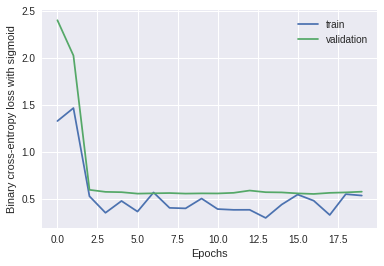

In [29]:
def plot_loss_curves(train, val):
    epochs = len(train)
    epoch = [i for i in range(epochs)]
    fig, ax = plt.subplots()
    ax.plot(epoch, train, label = 'train')
    ax.plot(epoch, val, label = 'validation')
    ax.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Binary cross-entropy loss with sigmoid')
    plt.show()

print(len(train_loss_history), len(val_loss_history))
plot_loss_curves(train_loss_history, val_loss_history)

## Grid search for hyperparameter tuning

In [36]:
def grid_search():
    ''' 
    A function to perform a basic grid search for hyperparameter tuning.

    The function evaluates different values of learning rates and of momentum in order to
    compare the performance of the stochastic gradient descent. 
    Returns the best parameter set and the corresponding accuracy.
    '''

    # Set random seeds for reproducible results
    torch.manual_seed(24)
    lr = [0.5, 0.3, 0.1, 0.05, 0.01]#, 0.005, 0.0001]
    momentum = [0, 0.3, 0.5, 0.9]
    parameters = [lr, momentum]

    best_f_score = 0 # Initialisation
    best_params = [None, None]

    # Set seed for reproducible results
    torch.manual_seed(24)

    for param1 in parameters[0]:
        for param2 in parameters[1]:
            start = time.time()
            print('Learning rate:', param1, '\tMomentum:', param2)

            # Create the neural network
            model = CNN(input_dim, embedding_dim, n_out_channels, window_size, output_dim, dropout)

            #model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

            optimizer = optim.SGD(model.parameters(), lr = param1, momentum = param2)
            loss_func = nn.BCEWithLogitsLoss()

            for epoch in range(1, epochs+1):
                # Training
                model.train()
                epoch_loss, epoch_acc = train_batch(model, optimizer, train_dl, loss_func)

                # On the validation dataset
                model.eval()
                predictions_valid, valid_loss, valid_acc = evaluation(model, val_data_tensor, val_label_tensor, loss_func)

            with torch.no_grad():
                f_score = f_measure(predictions_valid, val_label_tensor, False)

            if f_score > best_f_score:
                best_f_score = f_score
                best_params[0], best_params[1] = param1, param2

            duration = time.time() - start
            print('It takes {0:.6f} seconds for a learning rate of {1} and a momentum of {2}.'.format(duration, param1, param2))

    return best_params, best_f_score

grid_search()

Learning rate: 0.5 	Momentum: 0
It takes 237.487629 seconds for a learning rate of 0.5 and a momentum of 0.
Learning rate: 0.5 	Momentum: 0.3
It takes 180.897120 seconds for a learning rate of 0.5 and a momentum of 0.3.
Learning rate: 0.5 	Momentum: 0.5
It takes 134.093027 seconds for a learning rate of 0.5 and a momentum of 0.5.
Learning rate: 0.5 	Momentum: 0.9
It takes 142.345233 seconds for a learning rate of 0.5 and a momentum of 0.9.
Learning rate: 0.3 	Momentum: 0
It takes 119.853264 seconds for a learning rate of 0.3 and a momentum of 0.
Learning rate: 0.3 	Momentum: 0.3
It takes 279.510054 seconds for a learning rate of 0.3 and a momentum of 0.3.
Learning rate: 0.3 	Momentum: 0.5
It takes 173.496515 seconds for a learning rate of 0.3 and a momentum of 0.5.
Learning rate: 0.3 	Momentum: 0.9
It takes 168.846707 seconds for a learning rate of 0.3 and a momentum of 0.9.
Learning rate: 0.1 	Momentum: 0
It takes 136.016788 seconds for a learning rate of 0.1 and a momentum of 0.
Lear

([0.05, 0.9], 0.5714285714285714)

## Performance on the test dataset

In [30]:
# Test
print(test_data_tensor.shape)

model.eval()
predictions, loss, acc = evaluation(model, test_data_tensor, test_label_tensor, loss_func)

with torch.no_grad():
    print(predictions)
    print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')
    f_measure(predictions, test_label_tensor)

torch.Size([2648, 79])
tensor([ 2.1331, -1.2353,  0.3578,  ...,  0.0125, -1.2354,  1.2098])
| Test Loss: 0.598 | Test Acc: 73.23%
Test: Recall: 0.46, Precision: 0.65, F-measure: 0.54



In [31]:
#@title Confusion matrix
print(torch.round(torch.sigmoid(predictions)[0:10]))
#print(torch.round(torch.sigmoid(predictions)).unique())
y_pred = torch.round(torch.sigmoid(predictions)).detach().numpy().astype(int)
print(y_pred)
y_true = test_label_tensor.detach().numpy().astype(int)
print(y_true)
confusion_matrix(y_true, y_pred)

tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
[1 0 1 ... 1 0 1]
[1 0 0 ... 0 0 0]


array([[1527,  222],
       [ 487,  412]])

## Convert the output labels into the corresponding labels

In [32]:
def predict(raw_prediction):
    torch.manual_seed(24)
    y = torch.round(torch.sigmoid(raw_prediction)).detach().numpy().astype(int)
    y_pred = pd.DataFrame(y, columns = ['pred'])
    return y_pred

y_pred = predict(predictions)
y_pred['class'] = 'NOT'
y_pred.loc[y_pred['pred'] == 1, 'class'] = 'OFF'

y_pred.head()

,pred,class
0,1,OFF
1,0,NOT
2,1,OFF
3,0,NOT
4,0,NOT


## Training the model on the whole dataset

In [33]:
data_tensor_a, label_tensor_a = get_model_inputs(fin_df_a, word2idx, 'tweet', 'subtask_a', max_len_tweet)

train_data_a = TensorDataset(data_tensor_a, label_tensor_a)
train_dl_a = DataLoader(train_data_a, batch_size = batch_size)

# Set random seeds for reproducible results
torch.manual_seed(24)

model_a = CNN(input_dim, embedding_dim, n_out_channels, window_size, output_dim, dropout)

optimizer = optim.SGD(model_a.parameters(), lr = lr, momentum = momentum)
loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, epochs+1):
    # Training
    model_a.train()
    epoch_loss, epoch_acc = train_batch(model_a, optimizer, train_dl_a, loss_func)
    print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}% |')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
| Epoch: 01 | Train Loss: 2.936 | Train Acc: 53.33% |
| Epoch: 02 | Train Loss: 0.784 | Train Acc: 60.00% |
| Epoch: 03 | Train Loss: 0.610 | Train Acc: 80.00% |
| Epoch: 04 | Train Loss: 0.469 | Train Acc: 80.00% |
| Epoch: 05 | Train Loss: 0.418 | Train Acc: 86.67% |
| Epoch: 06 | Train Loss: 0.424 | Train Acc: 86.67% |
| Epoch: 07 | Train Loss: 0.564 | Train Acc: 80.00% |
| Epoch: 08 | Train Loss: 0.421 | Train Acc: 86.67% |
| Epoch: 09 | Train Loss: 0.398 | Train Acc: 86.67% |
| Epoch: 10 | Train Loss: 0.459 | Train Acc: 80.00% |
| Epoch: 11 | Train Loss: 0.445 | Train Acc: 80.00% |
| Epoch: 12 | Train Loss: 0.451 | Train Acc: 86.67% |
| Epoch: 13 | Train Loss: 0.489 | Train Acc: 66.67% |
| Epoch: 14 | Train Loss: 0.516 | Train Acc: 80.00% |
| Epoch: 15 | Train Loss: 0.452 | Train Acc: 80.00% |
| Epoch: 16 | Train Loss: 0.367 | Train Acc: 86.67% |
| Epoch: 17 | Train Loss: 0.419 | Train Acc: 86.67% |
| Epoch: 18

## Load the test dataset for submission

In [34]:
from google.colab import files
test_a = files.upload()

Saving testset-taska.tsv to testset-taska (2).tsv


In [35]:
df_sub_a = pd.read_csv(io.StringIO(test_a["testset-taska.tsv"].decode('utf-8')),  sep = "\t")
print(df_sub_a.shape)
df_sub_a.head()

(860, 2)


,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


##  Preproceessing from a raw dataframe to a preprocessed dataframe

In [36]:
def preprocessing_df(dataframe, label):
  # Remove punctuation, digits and some special characters
  df_prep = dataframe.copy()
  df_prep['preprocessed_tweet'] = df_prep[label].str.lower()
  df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('&amp;', '&')
  df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[{}]'.format(string.punctuation), '')
  df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[“”’—]', ' ')
  df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('\d+', '') # Remove digits
  df_prep = replace_words(df_prep, 'preprocessed_tweet')
  
  # Tokenisation
  token_df = df_prep.copy()
  token_df['token_tweet'] = token_df.preprocessed_tweet.apply(lambda x: x.split())
  
  # Remove stopwords
  token_df['token_tweet_stop'] = token_df['token_tweet'].apply(lambda x: [item for item in x if item not in mystopwords])
  
  
  sub_token_df = token_df[['id', 'token_tweet_stop']]#, 'subtask_a', 'subtask_b', 'subtask_c']]
  sub_token_df.rename(columns = {'token_tweet_stop':'tweet'}, inplace = True)
  
  return sub_token_df


# Preprocessing
df_test_a = preprocessing_df(df_sub_a, 'tweet')

# Lemmatisation
df_test_a = lemmatisation(df_test_a, 'tweet', False)

df_test_a.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,id,tweet,tweet_lemma
0,15923,"[whoisq, wherestheserver, dumpnike, declasfisa...","[whoisq, wherestheserver, dumpnike, declasfisa..."
1,27014,"[constitutionday, revered, conservatives, hate...","[constitutionday, revered, conservative, hated..."
2,30530,"[foxnews, nra, maga, potus, trump, ndamendment...","[foxnews, nra, maga, potus, trump, ndamendment..."
3,13876,"[watching, boomer, getting, news, still, parol...","[watching, boomer, getting, news, still, parol..."
4,60133,"[nopasaran, unity, demo, oppose, farright, lon...","[nopasaran, unity, demo, oppose, farright, lon..."


## Transform the test dataframe into an input for the neural network

In [37]:
def get_model_inputs_test(dataframe, word2idx, column, max_len):
  data = dataframe.copy()
  
  data['index_tweet'] = data[column].apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])
  
  data_tensor = Variable(torch.zeros((len(dataframe), max_len))).long()
  
  tweet_lengths = list(data['index_tweet'].map(len).values)
  
  for idx, (indices, tweet) in enumerate(zip(data['index_tweet'], tweet_lengths)):
    if idx % 1000 == 0:
      print(idx)

    data_tensor[idx, :tweet] = torch.LongTensor(indices)
  
  return data_tensor

test_a_input = get_model_inputs_test(df_test_a, word2idx, 'tweet_lemma', max_len_tweet)
print(test_a_input.shape)

0
torch.Size([860, 79])


## Predict the labels with the model trained on the whole training data

In [38]:
with torch.no_grad():
    predictions_task_a = model_a(test_a_input).squeeze(1)

y_pred = predict(predictions_task_a)
y_pred['class'] = 'NOT'
y_pred.loc[y_pred['pred'] == 1, 'class'] = 'OFF'

y_pred.describe(include = ['O'])

,class
count,860
unique,2
top,NOT
freq,711


## Export the predictions in the required format for submission

In [39]:
def submission(data, pred):
    df = data.copy()
    df['pred'] = pred['class']
    return df[['id', 'pred']]

subtask_a = submission(df_test_a, y_pred)
print(subtask_a.shape)
subtask_a.to_csv("result_subtask_a.csv", index = False, header = False)

(860, 2)


In [0]:
files.download('result_subtask_a.csv')

# Sub-task B

## Remove non offensive tweets

In [40]:
fin_df_b = sub_token_df[['id', 'tweet_lemma', 'subtask_b']]
fin_df_b.rename(columns = {'tweet_lemma':'tweet'}, inplace = True)
print(fin_df_b.shape)

fin_df_b_fil =fin_df_b.dropna()
print(fin_df_b_fil.shape) # 4400

(13240, 3)
(4400, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Split the data for sub-task B into three datasets

In [41]:
# Train Test Val Split: 80-20-20
df_train, df_test = train_test_split(fin_df_b_fil, test_size = 0.2, random_state = 24)
df_train, df_val = train_test_split(df_train, test_size = 0.25, random_state = 24)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
df_train.head()

(2640, 3)
(880, 3)
(880, 3)


,id,tweet,subtask_b
7981,70376,"[user, user, inciting, violence, via, twitter,...",TIN
721,89795,"[user, angela, hook, younger, guy, someone, wi...",TIN
6971,16743,"[user, today, collins, back, another, excuse, ...",TIN
6205,98434,"[user, holy, shit, way]",UNT
2932,95210,"[good, job, assholeyou, killed, dad, chance, g...",TIN


## Transform the given data into an input for the neural network

In [42]:
def get_model_inputs_b(dataframe, word2idx, column, target, max_len):
    # Input
    data = dataframe.copy()
    data['index_tweet'] = data.tweet.apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])

    data_tensor = Variable(torch.zeros((len(dataframe), max_len))).long()

    tweet_lengths = list(data['index_tweet'].map(len).values)

    for idx, (indices, tweet) in enumerate(zip(data['index_tweet'], tweet_lengths)):
        if idx % 1000 == 0:
            print(idx)
        data_tensor[idx, :tweet] = torch.LongTensor(indices)

    # Labels
    labels = dataframe[target].copy()
    labels[labels == 'TIN'] = 1.
    labels[labels == 'UNT'] = 0.
    labels_val = labels.values.astype(dtype = 'float32')
    label_tensor = torch.from_numpy(labels_val)

    return data_tensor, label_tensor

train_data_tensor, train_label_tensor = get_model_inputs_b(df_train, word2idx, 'tweet', 'subtask_b', max_len_tweet)

print(train_data_tensor.shape)

0
1000
2000
torch.Size([2640, 79])


In [43]:
# Validation
val_data_tensor, val_label_tensor = get_model_inputs_b(df_val, word2idx, 'tweet', 'subtask_b', max_len_tweet)

# Testing
test_data_tensor, test_label_tensor = get_model_inputs_b(df_test, word2idx, 'tweet', 'subtask_b', max_len_tweet)

0
0


In [44]:
# Transform the training data into a Pytorch DataLoader object
# Data loading
batch_size = 15 #75

# Training
print(train_data_tensor.shape)
train_data = TensorDataset(train_data_tensor, train_label_tensor)
train_dl = DataLoader(train_data, batch_size = batch_size)

torch.Size([2640, 79])


## Training the neural network

In [45]:
# Binary classification
output_dim = 1

# Variables for the SDG
# Learning rate
lr = 0.05 #0.01

# Momentum
momentum = 0.5

# Neural network
model, train_loss_history, val_loss_history = train(train_dl, val_data_tensor, 
                                                    val_label_tensor, lr, epochs, input_dim, embedding_dim, 
                                                    n_out_channels, window_size, output_dim, dropout, 
                                                    momentum)

| Epoch: 01 | Train Loss: 0.466 | Train Acc: 80.00% | Val. Loss: 0.371 | Val. Acc: 87.39% |
| Epoch: 02 | Train Loss: 0.646 | Train Acc: 73.33% | Val. Loss: 0.365 | Val. Acc: 87.39% |
| Epoch: 03 | Train Loss: 0.551 | Train Acc: 80.00% | Val. Loss: 0.361 | Val. Acc: 87.27% |
| Epoch: 04 | Train Loss: 0.522 | Train Acc: 80.00% | Val. Loss: 0.371 | Val. Acc: 87.39% |
| Epoch: 05 | Train Loss: 0.420 | Train Acc: 80.00% | Val. Loss: 0.364 | Val. Acc: 87.50% |
| Epoch: 06 | Train Loss: 0.424 | Train Acc: 80.00% | Val. Loss: 0.365 | Val. Acc: 86.93% |
| Epoch: 07 | Train Loss: 0.383 | Train Acc: 80.00% | Val. Loss: 0.367 | Val. Acc: 87.27% |
| Epoch: 08 | Train Loss: 0.497 | Train Acc: 80.00% | Val. Loss: 0.376 | Val. Acc: 87.05% |
| Epoch: 09 | Train Loss: 0.408 | Train Acc: 73.33% | Val. Loss: 0.391 | Val. Acc: 86.82% |
| Epoch: 10 | Train Loss: 0.473 | Train Acc: 73.33% | Val. Loss: 0.387 | Val. Acc: 86.93% |
| Epoch: 11 | Train Loss: 0.231 | Train Acc: 86.67% | Val. Loss: 0.393 | Val. Ac

## Plot the training and validation loss

20 20


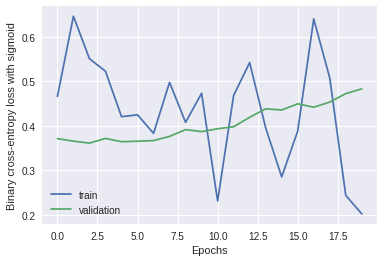

In [46]:
print(len(train_loss_history), len(val_loss_history))
plot_loss_curves(train_loss_history, val_loss_history)

## Grid search for hyperparameter tuning

In [58]:
def grid_search():

    # Set random seeds for reproducible results
    torch.manual_seed(24)
    lr = [0.5, 0.3, 0.1, 0.05, 0.01]#, 0.005, 0.0001]
    momentum = [0, 0.3, 0.5, 0.9]
    parameters = [lr, momentum]

    best_f_score = 0 # Initialisation
    best_params = [None, None]

    # Set seed for reproducible results
    torch.manual_seed(24)

    for param1 in parameters[0]:
        for param2 in parameters[1]:
            start = time.time()
            print('Learning rate:', param1, '\tMomentum:', param2)

            # Create the neural network
            model = CNN(input_dim, embedding_dim, n_out_channels, window_size, output_dim, dropout)

            #model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

            optimizer = optim.SGD(model.parameters(), lr = param1, momentum = param2)
            loss_func = nn.BCEWithLogitsLoss()

            for epoch in range(1, epochs+1):
                # Training
                model.train()
                epoch_loss, epoch_acc = train_batch(model, optimizer, train_dl, loss_func)

                # On the validation dataset
                model.eval()
                predictions_valid, valid_loss, valid_acc = evaluation(model, val_data_tensor, val_label_tensor, loss_func)

            with torch.no_grad():
                f_score = f_measure(predictions_valid, val_label_tensor, False)

            if f_score > best_f_score:
                best_f_score = f_score
                best_params[0], best_params[1] = param1, param2

            duration = time.time() - start
            print('It takes {0:.6f} seconds for a learning rate of {1} and a momentum of {2}.'.format(duration, param1, param2))

    return best_params, best_f_score

grid_search()

Learning rate: 0.5 	Momentum: 0
It takes 97.347951 seconds for a learning rate of 0.5 and a momentum of 0.
Learning rate: 0.5 	Momentum: 0.3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


It takes 109.555528 seconds for a learning rate of 0.5 and a momentum of 0.3.
Learning rate: 0.5 	Momentum: 0.5
It takes 102.544417 seconds for a learning rate of 0.5 and a momentum of 0.5.
Learning rate: 0.5 	Momentum: 0.9
It takes 106.038599 seconds for a learning rate of 0.5 and a momentum of 0.9.
Learning rate: 0.3 	Momentum: 0
It takes 86.729223 seconds for a learning rate of 0.3 and a momentum of 0.
Learning rate: 0.3 	Momentum: 0.3
It takes 112.463213 seconds for a learning rate of 0.3 and a momentum of 0.3.
Learning rate: 0.3 	Momentum: 0.5
It takes 104.179766 seconds for a learning rate of 0.3 and a momentum of 0.5.
Learning rate: 0.3 	Momentum: 0.9
It takes 109.030890 seconds for a learning rate of 0.3 and a momentum of 0.9.
Learning rate: 0.1 	Momentum: 0
It takes 85.874569 seconds for a learning rate of 0.1 and a momentum of 0.
Learning rate: 0.1 	Momentum: 0.3
It takes 111.868499 seconds for a learning rate of 0.1 and a momentum of 0.3.
Learning rate: 0.1 	Momentum: 0.5
It

([0.01, 0], 0.9326864766525167)

## Performance on the test dataset

In [47]:
print(test_data_tensor.shape)

model.eval()
predictions, loss, acc = evaluation(model, test_data_tensor, test_label_tensor, loss_func)

with torch.no_grad():
    #print(predictions)
    print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')
    f_measure(predictions, test_label_tensor)

torch.Size([880, 79])
| Test Loss: 0.414 | Test Acc: 88.86%
Test: Recall: 0.99, Precision: 0.89, F-measure: 0.94



In [48]:
#@title Confusion matrix
print(torch.round(torch.sigmoid(predictions)[0:10]))
print(torch.round(torch.sigmoid(predictions)).unique())
y_pred = torch.round(torch.sigmoid(predictions)).detach().numpy().astype(int)
#print(y_pred)
y_true = test_label_tensor.detach().numpy().astype(int)
#print(y_true)
confusion_matrix(y_true, y_pred)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 1.])


array([[  2,  92],
       [  6, 780]])

## Training the model on the whole dataset

In [49]:
data_tensor_b, label_tensor_b = get_model_inputs_b(fin_df_b_fil, word2idx, 'tweet', 'subtask_b', max_len_tweet)

train_data_b = TensorDataset(data_tensor_b, label_tensor_b)
train_dl_b = DataLoader(train_data_b, batch_size = batch_size)

# Set random seeds for reproducible results
torch.manual_seed(24)

model_b = CNN(input_dim, embedding_dim, n_out_channels, window_size, output_dim, dropout)

optimizer = optim.SGD(model_b.parameters(), lr = lr, momentum = momentum)
loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, epochs+1):
    # Training
    model_b.train()
    epoch_loss, epoch_acc = train_batch(model_b, optimizer, train_dl_b, loss_func)
    print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}% |')


0
1000
2000
3000
4000
| Epoch: 01 | Train Loss: 0.494 | Train Acc: 80.00% |
| Epoch: 02 | Train Loss: 0.256 | Train Acc: 100.00% |
| Epoch: 03 | Train Loss: 0.231 | Train Acc: 80.00% |
| Epoch: 04 | Train Loss: 0.245 | Train Acc: 80.00% |
| Epoch: 05 | Train Loss: 0.274 | Train Acc: 80.00% |
| Epoch: 06 | Train Loss: 0.158 | Train Acc: 100.00% |
| Epoch: 07 | Train Loss: 0.174 | Train Acc: 100.00% |
| Epoch: 08 | Train Loss: 0.206 | Train Acc: 80.00% |
| Epoch: 09 | Train Loss: 0.321 | Train Acc: 80.00% |
| Epoch: 10 | Train Loss: 0.212 | Train Acc: 80.00% |
| Epoch: 11 | Train Loss: 0.304 | Train Acc: 80.00% |
| Epoch: 12 | Train Loss: 0.168 | Train Acc: 100.00% |
| Epoch: 13 | Train Loss: 0.293 | Train Acc: 80.00% |
| Epoch: 14 | Train Loss: 0.233 | Train Acc: 80.00% |
| Epoch: 15 | Train Loss: 0.227 | Train Acc: 80.00% |
| Epoch: 16 | Train Loss: 0.162 | Train Acc: 80.00% |
| Epoch: 17 | Train Loss: 0.200 | Train Acc: 80.00% |
| Epoch: 18 | Train Loss: 0.206 | Train Acc: 80.00% |
| 

## Load the test dataset for submission

In [50]:
from google.colab import files
test_b = files.upload()

Saving testset-taskb.tsv to testset-taskb (2).tsv


In [51]:
df_sub_b = pd.read_csv(io.StringIO(test_b["testset-taskb.tsv"].decode('utf-8')),  sep = "\t")
print(df_sub_b.shape)
df_sub_b.head()

(240, 2)


,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,60133,#NoPasaran: Unity demo to oppose the far-right...
2,83681,. . . What the fuck did he do this time?
3,65507,@USER Do you get the feeling he is kissing @US...
4,12588,@USER Nigga ware da hits at


## Prediction with the trained model

In [52]:
# Preprocessing
df_test_b = preprocessing_df(df_sub_b, 'tweet')

# Lemmatisation
df_test_b = lemmatisation(df_test_b, 'tweet', False)

df_test_b.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,id,tweet,tweet_lemma
0,15923,"[whoisq, wherestheserver, dumpnike, declasfisa...","[whoisq, wherestheserver, dumpnike, declasfisa..."
1,60133,"[nopasaran, unity, demo, oppose, farright, lon...","[nopasaran, unity, demo, oppose, farright, lon..."
2,83681,"[fuck, time]","[fuck, time]"
3,65507,"[user, get, feeling, kissing, user, behind, hu...","[user, get, feeling, kissing, user, behind, hu..."
4,12588,"[user, nigga, ware, da, hits]","[user, nigga, ware, da, hit]"


In [53]:
test_b_input = get_model_inputs_test(df_test_b, word2idx, 'tweet_lemma', max_len_tweet)
print(test_b_input.shape)

0
torch.Size([240, 79])


In [54]:
with torch.no_grad():
    predictions_task_b = model_b(test_b_input).squeeze(1)

y_pred = predict(predictions_task_b)
y_pred['class'] = 'UNT'
y_pred.loc[y_pred['pred'] == 1, 'class'] = 'TIN'

y_pred.describe(include = ['O'])

,class
count,240
unique,2
top,TIN
freq,227


## Export the predictions in the required format for submission

In [55]:
subtask_b = submission(df_test_b, y_pred)
print(subtask_b.shape)
subtask_b.to_csv("result_subtask_b.csv", index = False, header = False)

(240, 2)


In [0]:
files.download('result_subtask_b.csv')

# Sub-task C

## Remove untargeted offensive tweets

In [56]:
fin_df_c = sub_token_df[['id', 'tweet_lemma', 'subtask_c']]
fin_df_c.rename(columns = {'tweet_lemma':'tweet'}, inplace = True)
print(fin_df_c.shape)

fin_df_c_fil =fin_df_c.dropna()
print(fin_df_c_fil.shape) # 3876

(13240, 3)
(3876, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Split the data for sub-task C into three datasets

In [57]:
df_train, df_test = train_test_split(fin_df_c_fil, test_size = 0.2, random_state = 24)
df_train, df_val = train_test_split(df_train, test_size = 0.25, random_state = 24)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
df_train.head()

(2325, 3)
(775, 3)
(776, 3)


,id,tweet,subtask_c
7426,26171,"[long, as, blog, might, make, sense, url]",OTH
7012,40282,"[user, one, crazy, person]",IND
11813,59464,"[user, user, probably, violent, liberal, antif...",IND
7689,81738,"[user, wrong, percent, time, bed, laying, sunt...",IND
9675,40262,"[user, user, yep, produce, article, shut, libe...",GRP


## Transform the given data into an input for the neural network

In [58]:
def get_model_inputs_c(dataframe, word2idx, column, target, max_len):
  data = dataframe.copy()
  
  # Convert words to index
  data['index_tweet'] = data.tweet.apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])
  
  # we create a tensor of a fixed size filled with zeroes for padding
  #data_tensor = Variable(torch.zeros((len(dataframe), max_len, embedding)))#.long() # Shape: No_tweets x maximum_length of tweets x embedding
  data_tensor = Variable(torch.zeros((len(dataframe), max_len))).long()
  
  tweet_lengths = list(data['index_tweet'].map(len).values)
  
  # we fill it with the indexes
  for idx, (indices, tweet) in enumerate(zip(data['index_tweet'], tweet_lengths)):
        if idx % 1000 == 0:
            print(idx)
        data_tensor[idx, :tweet] = torch.LongTensor(indices)


  # Labels
  #labels = dataframe[target].copy()
  labels = pd.get_dummies(dataframe[target].copy())
  print(labels.head())
  labels_val = labels.values.astype(dtype = 'float32')
  label_tensor = torch.from_numpy(labels_val)
  
  return data_tensor, label_tensor


train_data_tensor, train_label_tensor = get_model_inputs_c(df_train, word2idx, 'tweet', 'subtask_c', max_len_tweet)

print(train_data_tensor.shape)
print(train_label_tensor.shape)

0
1000
2000
       GRP  IND  OTH
7426     0    0    1
7012     0    1    0
11813    0    1    0
7689     0    1    0
9675     1    0    0
torch.Size([2325, 79])
torch.Size([2325, 3])


In [59]:
# Validation
val_data_tensor, val_label_tensor = get_model_inputs_c(df_val, word2idx, 'tweet', 'subtask_c', max_len_tweet)

# Testing
test_data_tensor, test_label_tensor = get_model_inputs_c(df_test, word2idx, 'tweet', 'subtask_c', max_len_tweet)

0
       GRP  IND  OTH
11454    0    1    0
11930    1    0    0
5332     0    1    0
2558     0    1    0
11850    0    1    0
0
       GRP  IND  OTH
3343     0    1    0
6868     0    1    0
10597    0    1    0
1830     0    1    0
937      0    0    1


In [0]:
# Data loading
# Training
train_data = TensorDataset(train_data_tensor, train_label_tensor)
train_dl = DataLoader(train_data, batch_size = batch_size)

## Training the neural network

In [61]:
def mult_accuracy(output, target):
    acc_list = []
    for i in range(3):
      acc_list += [accuracy(torch.round(output[:, i]), target[:, i])]
    return sum(acc_list) / len(acc_list)

# Variables
# Multiclass (3 classes) classification
output_dim = 3

# Variables for the SDG
# Learning rate
lr = 0.05 #0.01

# Momentum
momentum = 0 #0.5


model, train_loss_history, val_loss_history = train(train_dl, val_data_tensor, 
                                                    val_label_tensor, lr, epochs, input_dim, embedding_dim, 
                                                    n_out_channels, window_size, output_dim, dropout, 
                                                    momentum)

# Ignore the accuracy value

| Epoch: 01 | Train Loss: 0.494 | Train Acc: 233.33% | Val. Loss: 0.540 | Val. Acc: 220.13% |
| Epoch: 02 | Train Loss: 0.508 | Train Acc: 246.67% | Val. Loss: 0.528 | Val. Acc: 223.35% |
| Epoch: 03 | Train Loss: 0.484 | Train Acc: 240.00% | Val. Loss: 0.519 | Val. Acc: 225.29% |
| Epoch: 04 | Train Loss: 0.544 | Train Acc: 240.00% | Val. Loss: 0.520 | Val. Acc: 225.03% |
| Epoch: 05 | Train Loss: 0.531 | Train Acc: 233.33% | Val. Loss: 0.516 | Val. Acc: 225.68% |
| Epoch: 06 | Train Loss: 0.512 | Train Acc: 233.33% | Val. Loss: 0.507 | Val. Acc: 225.68% |
| Epoch: 07 | Train Loss: 0.496 | Train Acc: 240.00% | Val. Loss: 0.516 | Val. Acc: 225.16% |
| Epoch: 08 | Train Loss: 0.409 | Train Acc: 240.00% | Val. Loss: 0.503 | Val. Acc: 226.19% |
| Epoch: 09 | Train Loss: 0.487 | Train Acc: 240.00% | Val. Loss: 0.514 | Val. Acc: 225.68% |
| Epoch: 10 | Train Loss: 0.500 | Train Acc: 233.33% | Val. Loss: 0.500 | Val. Acc: 226.84% |
| Epoch: 11 | Train Loss: 0.433 | Train Acc: 266.67% | Val. 

20 20


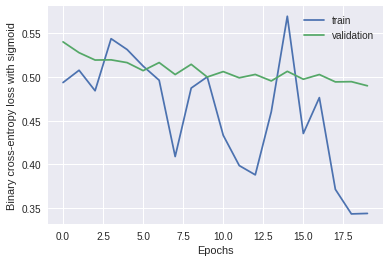

In [62]:
print(len(train_loss_history), len(val_loss_history))
plot_loss_curves(train_loss_history, val_loss_history)

## Grid search for hyperparameter tuning

In [81]:
def grid_search():
    ''' 
    A function to perform a basic grid search for hyperparameter tuning.

    The function evaluates different values of learning rates and of momentum in order to
    compare the performance of the stochastic gradient descent. 
    Returns the best parameter set and the corresponding accuracy.
    '''

    # Set random seeds for reproducible results
    torch.manual_seed(24)
    lr = [0.5, 0.3, 0.1, 0.05, 0.01]
    momentum = [0, 0.3, 0.5, 0.9]
    parameters = [lr, momentum]

    best_f_score = 0 # Initialisation
    best_params = [None, None]

    # Set seed for reproducible results
    torch.manual_seed(24)

    for param1 in parameters[0]:
        for param2 in parameters[1]:
            start = time.time()
            print('Learning rate:', param1, '\tMomentum:', param2)

            # Create the neural network
            model = CNN(input_dim, embedding_dim, n_out_channels, window_size, output_dim, dropout)

            #model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

            optimizer = optim.SGD(model.parameters(), lr = param1, momentum = param2)
            loss_func = nn.BCEWithLogitsLoss()

            for epoch in range(1, epochs+1):
                # Training
                model.train()
                epoch_loss, epoch_acc = train_batch(model, optimizer, train_dl, loss_func)

                # On the validation dataset
                model.eval()
                predictions_valid, valid_loss, valid_acc = evaluation(model, val_data_tensor, val_label_tensor, loss_func)

            with torch.no_grad():
                f_score = f_measure(predictions_valid, val_label_tensor, False)

            if f_score > best_f_score:
                best_f_score = f_score
                best_params[0], best_params[1] = param1, param2

            duration = time.time() - start
            print('It takes {0:.6f} seconds for a learning rate of {1} and a momentum of {2}.'.format(duration, param1, param2))

    return best_params, best_f_score

grid_search()

Learning rate: 0.5 	Momentum: 0
Learning rate: 0.5 	Momentum: 0
It takes 43.019857 seconds for a learning rate of 0.5 and a momentum of 0.
Learning rate: 0.5 	Momentum: 0.3
It takes 43.019857 seconds for a learning rate of 0.5 and a momentum of 0.
Learning rate: 0.5 	Momentum: 0.3
It takes 50.544779 seconds for a learning rate of 0.5 and a momentum of 0.3.
Learning rate: 0.5 	Momentum: 0.5
It takes 50.544779 seconds for a learning rate of 0.5 and a momentum of 0.3.
Learning rate: 0.5 	Momentum: 0.5
It takes 47.944822 seconds for a learning rate of 0.5 and a momentum of 0.5.
Learning rate: 0.5 	Momentum: 0.9
It takes 47.944822 seconds for a learning rate of 0.5 and a momentum of 0.5.
Learning rate: 0.5 	Momentum: 0.9
It takes 45.929596 seconds for a learning rate of 0.5 and a momentum of 0.9.
Learning rate: 0.3 	Momentum: 0
It takes 45.929596 seconds for a learning rate of 0.5 and a momentum of 0.9.
Learning rate: 0.3 	Momentum: 0
It takes 40.089585 seconds for a learning rate of 0.3 an

([0.05, 0], 0.6360520904729267)

([0.05, 0], 0.6360520904729267)

## Performance on the test dataset

In [63]:
model.eval()
with torch.no_grad():
  predictions = model(test_data_tensor).squeeze(1)
  loss = loss_func(predictions, test_label_tensor)
  acc = mult_accuracy(torch.round(predictions), test_label_tensor)
  print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')
  f_measure(predictions, test_label_tensor)
  

| Test Loss: 0.481 | Test Acc: 77.15%
Test: Recall: 0.59, Precision: 0.70, F-measure: 0.64



In [64]:
#@title Confusion matrix
print(torch.round(torch.sigmoid(predictions)[0:5]))
y_pred = torch.round(torch.sigmoid(predictions)).argmax(dim = 1).detach().numpy().astype(int)
#print(y_pred)
y_true = test_label_tensor.argmax(dim = 1).detach().numpy().astype(int)
#print(y_true)
confusion_matrix(y_true ,y_pred)

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


array([[ 49, 117,  64],
       [ 16, 410,  36],
       [  9,  58,  17]])

## Training the model on the whole dataset

In [67]:
data_tensor_c, label_tensor_c = get_model_inputs_c(fin_df_c_fil, word2idx, 'tweet', 'subtask_c', max_len_tweet)

train_data_c = TensorDataset(data_tensor_c, label_tensor_c)
train_dl_c = DataLoader(train_data_c, batch_size = batch_size)

# Set random seeds for reproducible results
torch.manual_seed(24)

model_c = CNN(input_dim, embedding_dim, n_out_channels, window_size, output_dim, dropout)

optimizer = optim.SGD(model_c.parameters(), lr = lr, momentum = momentum)
loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, epochs+1):
    # Training
    model_c.train()
    epoch_loss, epoch_acc = train_batch(model_c, optimizer, train_dl_c, loss_func)
    print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f}')


0
1000
2000
3000
    GRP  IND  OTH
1     0    1    0
5     0    0    1
7     1    0    0
9     0    1    0
12    0    1    0
| Epoch: 01 | Train Loss: 0.863
| Epoch: 02 | Train Loss: 0.943
| Epoch: 03 | Train Loss: 1.023
| Epoch: 04 | Train Loss: 0.780
| Epoch: 05 | Train Loss: 0.855
| Epoch: 06 | Train Loss: 0.852
| Epoch: 07 | Train Loss: 0.799
| Epoch: 08 | Train Loss: 0.701
| Epoch: 09 | Train Loss: 0.628
| Epoch: 10 | Train Loss: 0.688
| Epoch: 11 | Train Loss: 0.820
| Epoch: 12 | Train Loss: 0.682
| Epoch: 13 | Train Loss: 0.505
| Epoch: 14 | Train Loss: 0.518
| Epoch: 15 | Train Loss: 0.600
| Epoch: 16 | Train Loss: 0.536
| Epoch: 17 | Train Loss: 0.498
| Epoch: 18 | Train Loss: 0.474
| Epoch: 19 | Train Loss: 0.576
| Epoch: 20 | Train Loss: 0.609


## Load the test dataset for submission

In [66]:
from google.colab import files
test_c = files.upload()

Saving test_set_taskc.tsv to test_set_taskc (2).tsv


In [68]:
df_sub_c = pd.read_csv(io.StringIO(test_c["test_set_taskc.tsv"].decode('utf-8')),  sep = "\t")
print(df_sub_c.shape)
df_sub_c.head()

(213, 2)


,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,60133,#NoPasaran: Unity demo to oppose the far-right...
2,83681,. . . What the fuck did he do this time?
3,65507,@USER Do you get the feeling he is kissing @US...
4,34263,#StopKavanaugh he is liar like the rest of the...


## Prediction with the trained model

In [69]:
# Pre-processing
df_test_c = preprocessing_df(df_sub_c, 'tweet')

# Lemmatisation
df_test_c = lemmatisation(df_test_c, 'tweet', False)

df_test_c.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,id,tweet,tweet_lemma
0,15923,"[whoisq, wherestheserver, dumpnike, declasfisa...","[whoisq, wherestheserver, dumpnike, declasfisa..."
1,60133,"[nopasaran, unity, demo, oppose, farright, lon...","[nopasaran, unity, demo, oppose, farright, lon..."
2,83681,"[fuck, time]","[fuck, time]"
3,65507,"[user, get, feeling, kissing, user, behind, hu...","[user, get, feeling, kissing, user, behind, hu..."
4,34263,"[stopkavanaugh, liar, like, rest, gop, url]","[stopkavanaugh, liar, like, rest, gop, url]"


In [70]:
test_c_input = get_model_inputs_test(df_test_c, word2idx, 'tweet_lemma', max_len_tweet)
print(test_c_input.shape)

0
torch.Size([213, 79])


In [71]:
with torch.no_grad():
    predictions_task_c = model_c(test_c_input).squeeze(1)

torch.manual_seed(24)
y = torch.round(torch.sigmoid(predictions_task_c)).argmax(dim = 1).detach().numpy().astype(int)
y_pred = pd.DataFrame(y, columns = ['pred'])


y_pred['class'] = 'OTH'
y_pred.loc[y_pred['pred'] == 0, 'class'] = 'GRP'
y_pred.loc[y_pred['pred'] == 1, 'class'] = 'IND'

y_pred.describe(include = ['O'])

,class
count,213
unique,3
top,IND
freq,130


##  Export the predictions in the required format for submission

In [0]:
subtask_c = submission(df_test_c, y_pred)
subtask_c.head()
subtask_c.to_csv("result_subtask_c.csv", index = False, header = False)

In [0]:
files.download('result_subtask_c.csv')